#### Loading stuff

In [210]:
%load_ext autoreload
%autoreload 2

import torch
from util.util_cnn import get_test_loader, CNN, test
device = "cpu"
PATH = './models/mnist_cnn.torch'

from util.util_gamma_rule import forw_surrogate_matrix, calc_evals_batch, plot_evals_lineplot, global_conv_matrix
from util.util_data_summary import percentile, nth_largest
from util.util_vector_fields import plot_vector_field, plot_vector_field_batch, rotation, rotation2, print_weights_list


import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Shear 2x2

In [50]:
W = np.array([[1, 1], [0, 1]])
p = np.ones(2) * 3
gammas = np.linspace(0, 8, 5)

np.random.seed(1)
matrix_noise = np.random.normal(0, 1, size=W.shape)
noise_levels = [0, 0.001, 0.01, 0.1, 1]
noise_levels = [0.1, 0.2, 0.5, 1, 2]
noise_levels = [0.1]

weights_list = [W + matrix_noise * lvl for lvl in noise_levels]

evals, evecs = calc_evals_batch(weights_list, [p], gammas, return_evecs=True)
# plot_evals_lineplot(evals, gammas)

2


/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:250: ComplexWarning: Casting complex values to real discards the imaginary part
  if return_evecs:


## Weighted sum of Two simple linear transformation

In [82]:
weights_list[3]

array([[ 0.25,  1.  ],
       [-0.75,  0.25]])

In [83]:
forw_surrogate_matrix(weights_list[3], p, 2.)

g 2.0
[[ 0.75  3.  ]
 [-0.75  0.75]]
[[0.25 1.  ]
 [ inf -inf]]
Unexpected exception formatting exception. Falling back to standard exception


/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:117: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:127: RuntimeWarning: invalid value encountered in matmul
  
Traceback (most recent call last):
  File "/Users/johannes/Applications/miniconda3/envs/msc/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/lb/gcgcmyt11lq2rbpmsb109yfh0000gn/T/ipykernel_67955/372806782.py", line 1, in <cell line: 1>
    forw_surrogate_matrix(weights_list[3], p, 2.)
  File "/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py", line 127, in forw_surrogate_matrix
    assert np.allclose(R_i_to_j @ curr,  W @ curr, atol=0.0001), f"Too high difference in outputs. Maximum point-wise diff: {np.abs((R_i_to_j @ curr) - (W @ curr)).max()}"
AssertionError: Too high difference in outputs. Maximum point-

[0.   0.25 0.5  0.75 1.  ]
2
0 0
1 0
2 0
3 0
4 0


/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:250: ComplexWarning: Casting complex values to real discards the imaginary part
  ret = calc_evals_sparse(W, point, gammas, num_evals) # TODO ret evecs


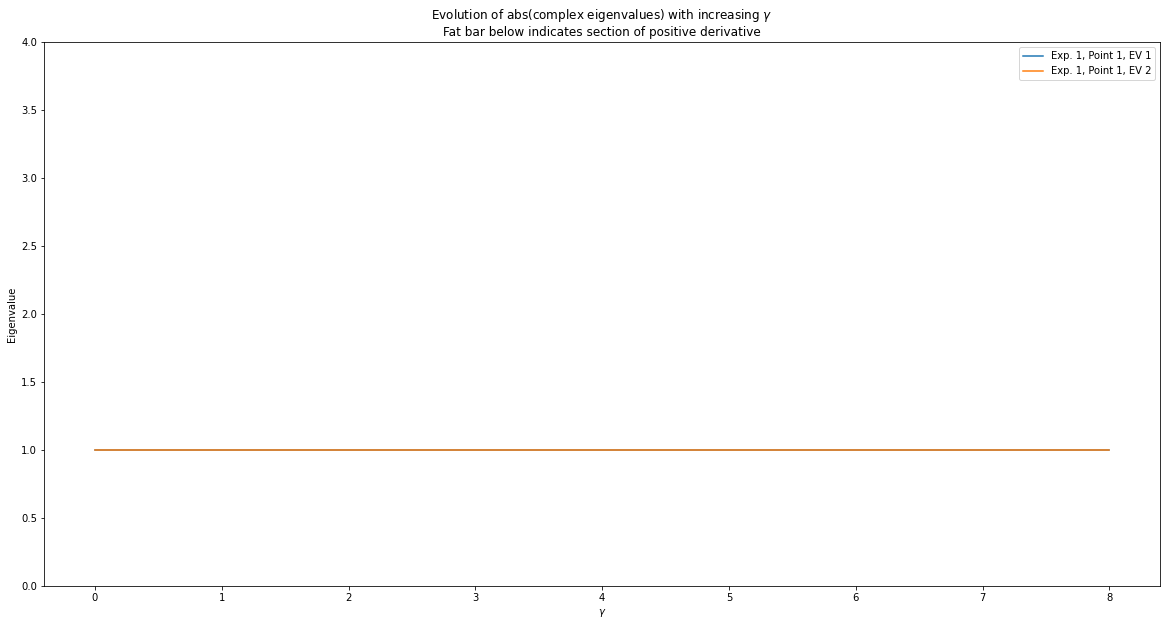

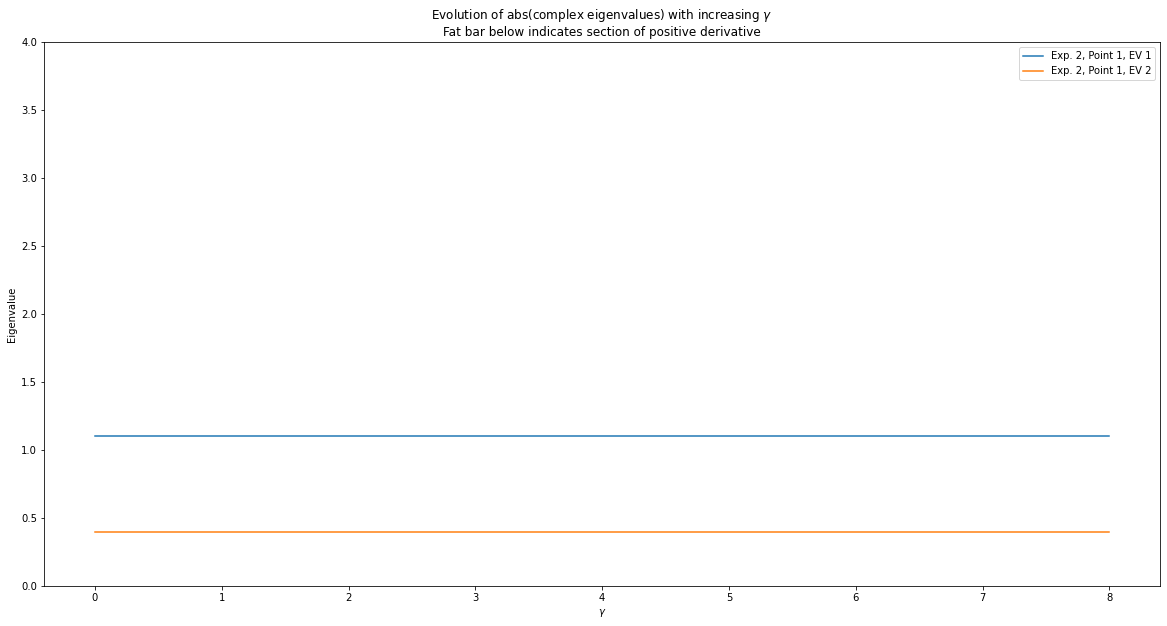

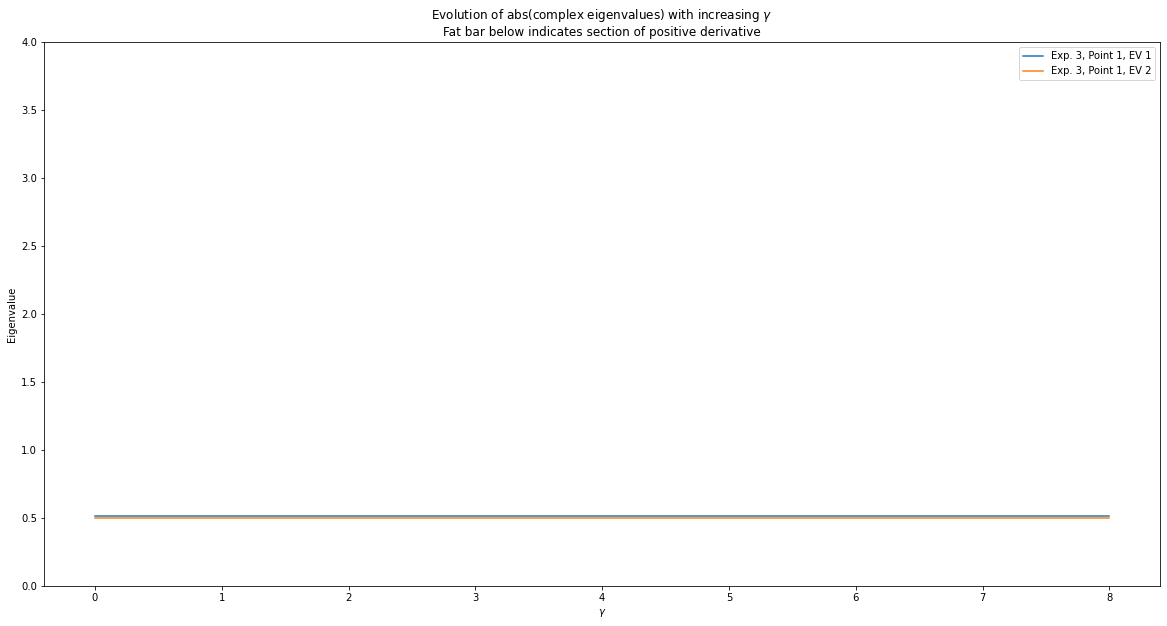

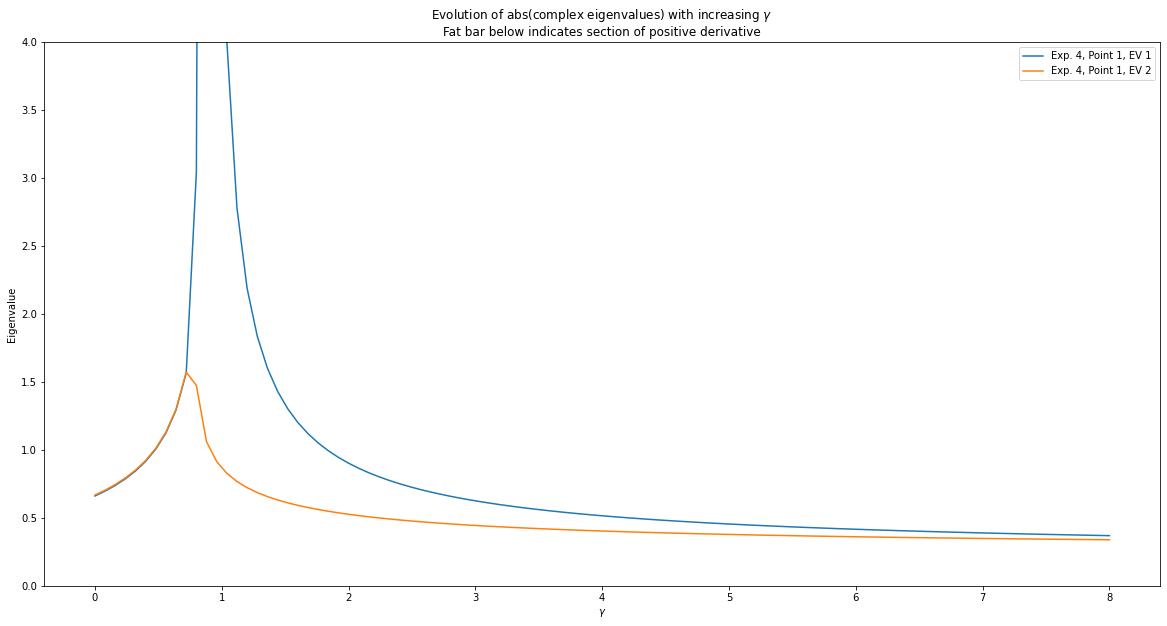

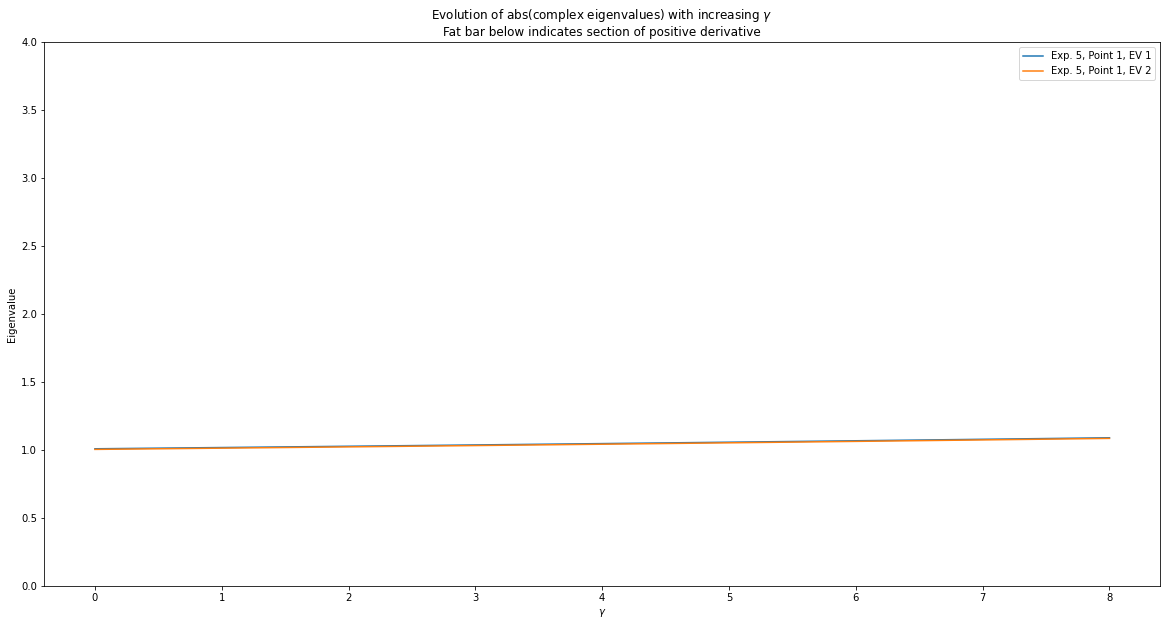

In [90]:
W1 = np.array([[1, 1], [0, 1]])     # shear
W2 = rotation(89)                   # ~90deg rotation
p = np.ones(2)
gammas = np.linspace(0, 8, 101)

mixture = np.linspace(0, 1, 5)
print(mixture)

weights_list = [(1-mix)*W1 + mix*W2 for mix in mixture]

evals, evecs = calc_evals_batch(weights_list, [p], gammas, return_evecs=True)
plot_evals_lineplot(evals, gammas)

In [97]:
x=np.array([.6,-.4])
i = np.ones(2)
for gamma in np.linspace(0,2,11):
    print('\n', gamma)
    y = x + gamma * x.clip(0,None)
    print(y)
    y *= x@i / y@i
    print(y)


 0.0
[ 0.6 -0.4]
-0.16666666666666663
[-0.1         0.06666667]

 0.2
[ 0.72 -0.4 ]
-0.22222222222222215
[-0.16        0.08888889]

 0.4
[ 0.84 -0.4 ]
-0.26190476190476186
[-0.22       0.1047619]

 0.6000000000000001
[ 0.96 -0.4 ]
-0.29166666666666663
[-0.28        0.11666667]

 0.8
[ 1.08 -0.4 ]
-0.31481481481481477
[-0.34        0.12592593]

 1.0
[ 1.2 -0.4]
-0.33333333333333326
[-0.4         0.13333333]

 1.2000000000000002
[ 1.32 -0.4 ]
-0.3484848484848484
[-0.46        0.13939394]

 1.4000000000000001
[ 1.44 -0.4 ]
-0.36111111111111105
[-0.52        0.14444444]

 1.6
[ 1.56 -0.4 ]
-0.3717948717948717
[-0.58        0.14871795]

 1.8
[ 1.68 -0.4 ]
-0.3809523809523809
[-0.64        0.15238095]

 2.0
[ 1.8 -0.4]
-0.3888888888888888
[-0.7         0.15555556]


[[1. 1.]
 [0. 1.]]


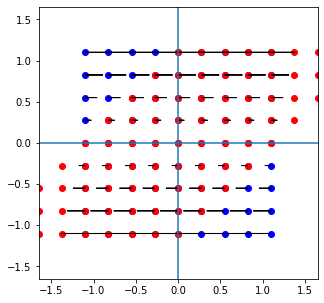

[[0.7543631  0.50003808]
 [0.24996192 0.7543631 ]]


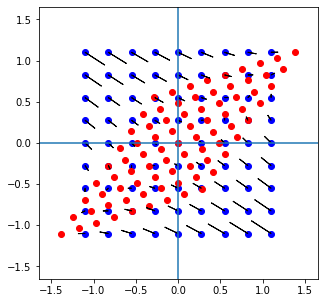

[[5.08726203e-01 7.61524218e-05]
 [4.99923848e-01 5.08726203e-01]]


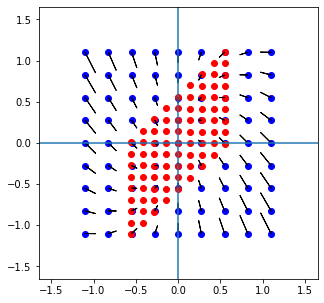

[[ 0.2630893  -0.49988577]
 [ 0.74988577  0.2630893 ]]


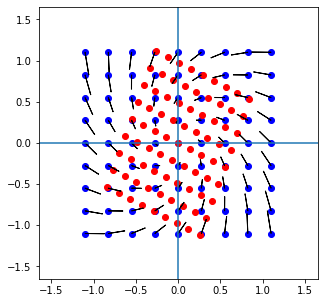

[[ 0.01745241 -0.9998477 ]
 [ 0.9998477   0.01745241]]


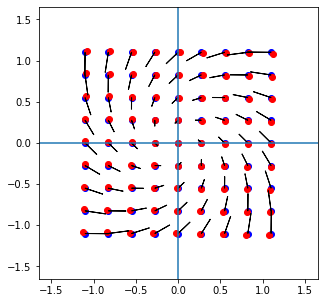

In [91]:
for W in weights_list:
    print(W)
    plot_vector_field(W, figsize=(5,5))
    plt.show()

## Plot rotation vecor field

[[ 1.          0.61237244]
 [-0.61237244  1.        ]]

[1.+0.61237244j 1.-0.61237244j]
[[0.        -0.70710678j 0.        +0.70710678j]
 [0.70710678+0.j         0.70710678-0.j        ]]


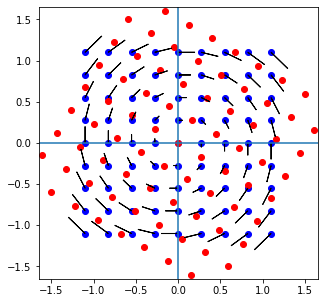

In [174]:
### free variables ###

discriminant = -1.5 # has to be negative for the matrix to have no real eigenvalues.

## seperation into streching and rotation ##

# (a-d)^2 + 4bc = discriminant < 0. <- Criteria for matrix to be a rotation with commplex eigenvectors.
# Easiest: a=d. Then b & c just need to have different signs.
# But if |a-d| is large, then b & c need to be very large (and of different signs). Otherwise the discriminant would be positive.
 
# -> a & d determine the stretching in x & y. If this stretching is not symmetric, we have 'less of an rotation'.
# -> b & c determine the rotation in x & y. The larger their magnitude, the 'stronger a rotation'.


## a & d ##

# a determines the stretching in x-direction.
# d determines the stretching in y-direction.
# if a = -d the result is stretched in both x & y direction by the same degree.
a_minus_d = 0
a = 1

## b & c ##

b_c_distribution = .5 # stretches rotation is x-direction (positive) or y-direction (negative). Only if a != -d.
b_is_positive = False # go counterclockwise?

W = rotation2(discriminant, a_minus_d, a, b_c_distribution, b_is_positive)
(a, b), (c, d) = W
print(W)
print()
evals, evecs = LA.eig(W)
print(evals)
print(evecs)
plot_vector_field(W, figsize=(5,5))

### Varying discriminant
- As $a-d=0$ is constant, the decreasing discribinant increases $|b| = |c|$. This increases the rotational spread, and the Determinant of the rotation.

[[ 1.  0.]
 [-0.  1.]]
Determinant: 1.0


/Users/johannes/Repositories/Masterarbeit/util/util_vector_fields.py:37: RuntimeWarning: invalid value encountered in true_divide
  


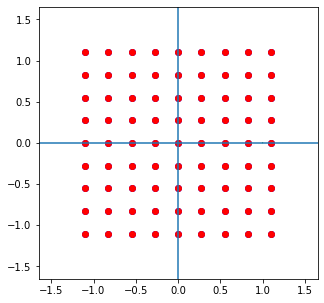

[[ 1.          0.35355339]
 [-0.35355339  1.        ]]
Determinant: 1.125


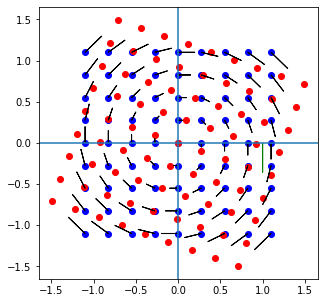

[[ 1.   0.5]
 [-0.5  1. ]]
Determinant: 1.25


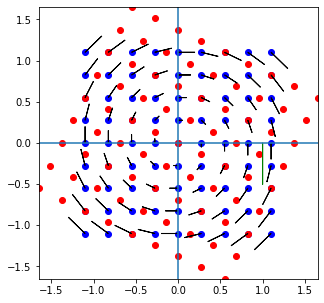

[[ 1.          0.70710678]
 [-0.70710678  1.        ]]
Determinant: 1.5


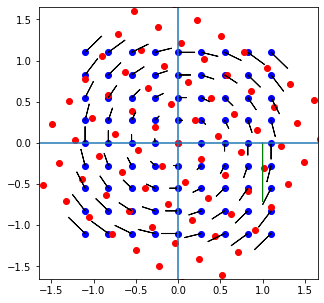

[[ 1.  1.]
 [-1.  1.]]
Determinant: 2.0


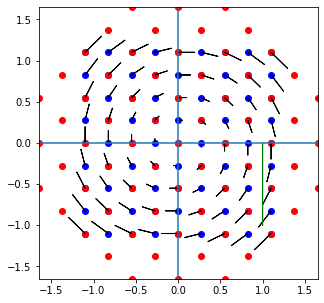

In [184]:
for disc in [0, -.5, -1, -2, -4]:
    W = rotation2(disc, a_minus_d=0, a=1, b_c_distribution=0, b_is_positive=False)
    print(W)
    print("Determinant:", LA.det(W))
    plot_vector_field(W, figsize=(5,5))
    p=np.array([1,0])
    plt.arrow(*p, *(W@p - p), color='green')
    plt.show()


### Varying $|a| = |d|$
- As $a-d=0$ is constant, we vary $|a| = |d|$. This can be interpreted as the "departure angle".

[[ 1.          0.70710678]
 [-0.70710678  1.        ]]
Determinant: 1.5


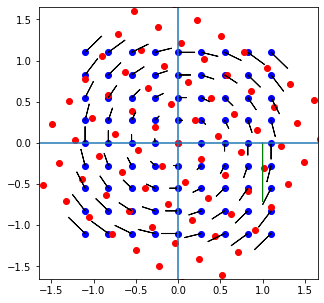

[[ 0.5         0.70710678]
 [-0.70710678  0.5       ]]
Determinant: 0.7500000000000001


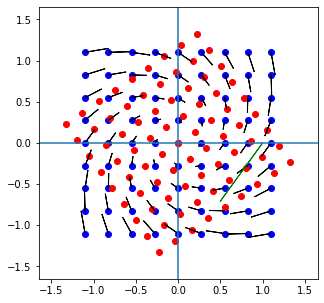

[[ 0.          0.70710678]
 [-0.70710678  0.        ]]
Determinant: 0.5000000000000001


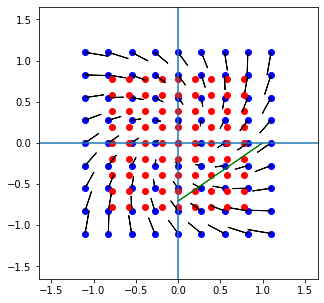

[[-0.5         0.70710678]
 [-0.70710678 -0.5       ]]
Determinant: 0.7500000000000001


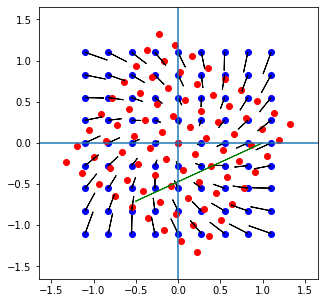

[[-1.          0.70710678]
 [-0.70710678 -1.        ]]
Determinant: 1.5


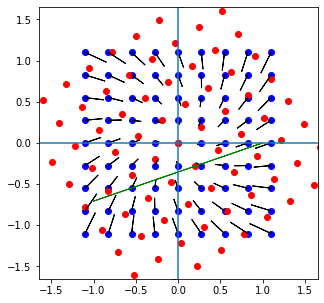

In [188]:
for a in [1, .5, 0, -.5, -1]:
    W = rotation2(discriminant=-2, a_minus_d=0, a=a, b_c_distribution=0, b_is_positive=False)
    print(W)
    print("Determinant:", LA.det(W))
    plot_vector_field(W, figsize=(5,5))
    p=np.array([1,0])
    plt.arrow(*p, *(W@p - p), color='green')
    plt.show()


### Varying $a-d$
- Similar

[[ 1.         0.8660254]
 [-0.8660254  0.       ]]
Determinant: 0.7499999999999999


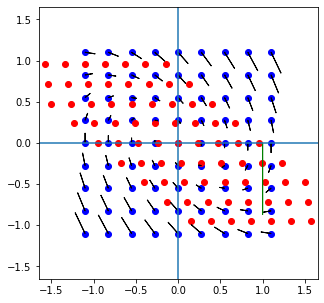

[[ 1.    0.75]
 [-0.75  0.5 ]]
Determinant: 1.0625


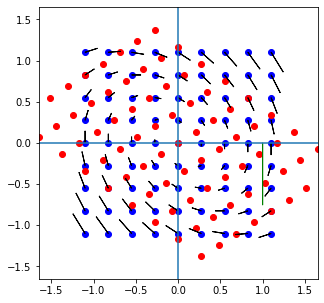

[[ 1.          0.70710678]
 [-0.70710678  1.        ]]
Determinant: 1.5


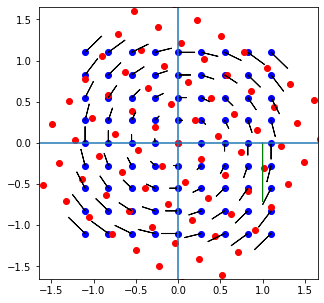

[[ 1.    0.75]
 [-0.75  1.5 ]]
Determinant: 2.0625


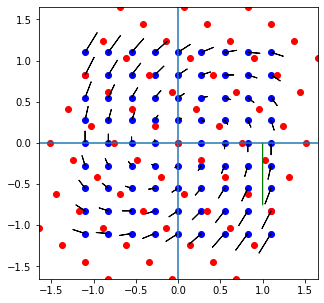

[[ 1.         0.8660254]
 [-0.8660254  2.       ]]
Determinant: 2.75


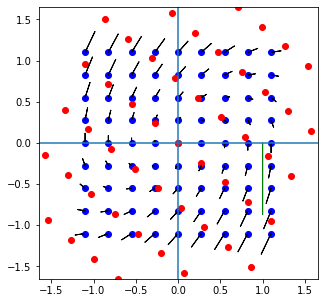

In [190]:
for amd in [1, .5, 0, -.5, -1]:
    W = rotation2(discriminant=-2, a_minus_d=amd, a=1, b_c_distribution=0, b_is_positive=False)
    print(W)
    print("Determinant:", LA.det(W))
    plot_vector_field(W, figsize=(5,5))
    p=np.array([1,0])
    plt.arrow(*p, *(W@p - p), color='green')
    plt.show()


### Varying $b, c$ with $b \cdot c = const.$
- Changes wether there is more 'rotational spread' in x or y direction.

[[ 1.          0.35355339]
 [-1.41421356  1.        ]]
Determinant: 1.5


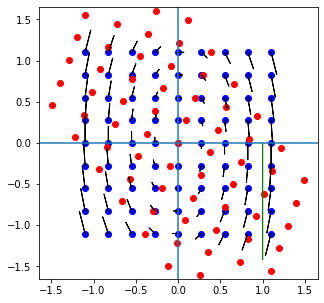

[[ 1.   0.5]
 [-1.   1. ]]
Determinant: 1.5


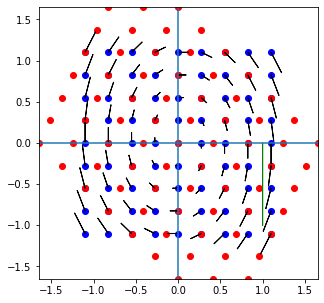

[[ 1.          0.70710678]
 [-0.70710678  1.        ]]
Determinant: 1.5


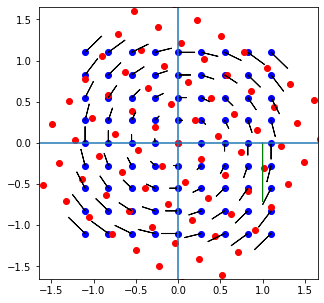

[[ 1.   1. ]
 [-0.5  1. ]]
Determinant: 1.5


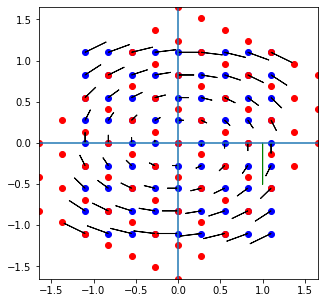

[[ 1.          1.41421356]
 [-0.35355339  1.        ]]
Determinant: 1.5


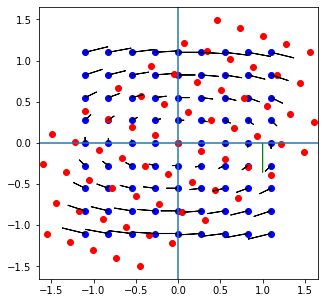

In [191]:
for bcd in [1, .5, 0, -.5, -1]:
    W = rotation2(discriminant=-2, a_minus_d=0, a=1, b_c_distribution=bcd, b_is_positive=False)
    print(W)
    print("Determinant:", LA.det(W))
    plot_vector_field(W, figsize=(5,5))
    p=np.array([1,0])
    plt.arrow(*p, *(W@p - p), color='green')
    plt.show()


## Forward surrogate matrices for different Rotation matrices

In [274]:
weights_list = [rotation2(discriminant=discriminant, a_minus_d=0, a=1, b_c_distribution=0) for discriminant in [0, -.5, -1, -2, -4, -8]]
points_list = [
    [1, 1],
    [np.sqrt(.5), np.sqrt(.5)],
    [0, 1],
    [1, 0],
]

gammas = np.linspace(0, 3, 20)
print(gammas)

computed_evals = calc_evals_batch(weights_list, points_list, gammas=gammas)

[0.         0.15789474 0.31578947 0.47368421 0.63157895 0.78947368
 0.94736842 1.10526316 1.26315789 1.42105263 1.57894737 1.73684211
 1.89473684 2.05263158 2.21052632 2.36842105 2.52631579 2.68421053
 2.84210526 3.        ]
2


In [275]:
# normalize matrices to determinant 1
print([round(LA.det(W), 2) for W in weights_list])
weights_list = [W * LA.det(W)**-.5 for W in weights_list]
print([round(LA.det(W), 2) for W in weights_list])

[1.0, 1.12, 1.25, 1.5, 2.0, 3.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [298]:
print_weights_list(weights_list)

       [[ 1.  0.]                    [[ 0.94  0.33]                [[ 0.89  0.45]                [[ 0.82  0.58]                [[ 0.71  0.71]                [[ 0.58  0.82]                
        [-0.  1.]]                    [-0.33  0.94]]                [-0.45  0.89]]                [-0.58  0.82]]                [-0.71  0.71]]                [-0.82  0.58]]               


/Users/johannes/Repositories/Masterarbeit/util/util_vector_fields.py:39: RuntimeWarning: invalid value encountered in true_divide
  diffs_smaller = diffs / max_len * step # reduce length, such that each arrow can not be longer than 'step'


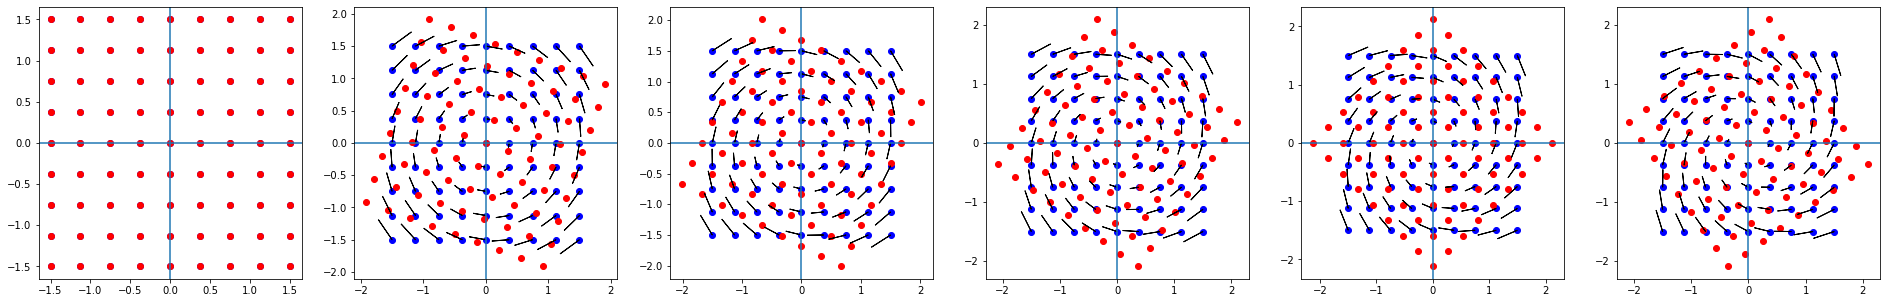

In [276]:
plot_vector_field_batch(weights_list, lims = np.array([-1.5, 1.5]))

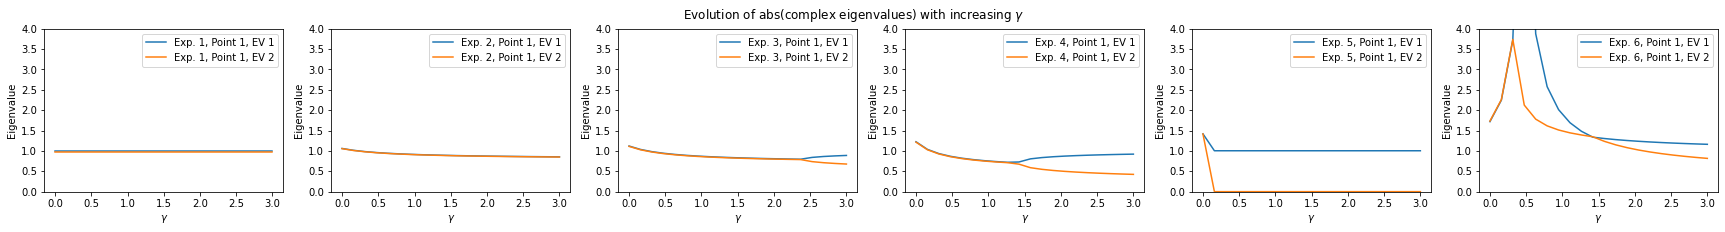

In [277]:
plot_evals_lineplot(computed_evals[:, :1], gammas, one_plot_per='weight', mark_positive_slope=False)

In [299]:
plot_at_gamma = .25
weights_list_prime = [forw_surrogate_matrix(W, p, plot_at_gamma) for W in weights_list]

- Interesting: The time when 2 abs(eigenvalues) seperate, is when the pair is not complex anymore, but real-valued. 
- Then two dimensions don't rotate anymore.
- This seems to happen earlier the larger the rotational speed.

In [125]:
W

array([[ 0.5,  1. ],
       [-1. ,  0.5]])

[0.         0.15789474 0.31578947 0.47368421 0.63157895 0.78947368
 0.94736842 1.10526316 1.26315789 1.42105263 1.57894737 1.73684211
 1.89473684 2.05263158 2.21052632 2.36842105 2.52631579 2.68421053
 2.84210526 3.        ]
2


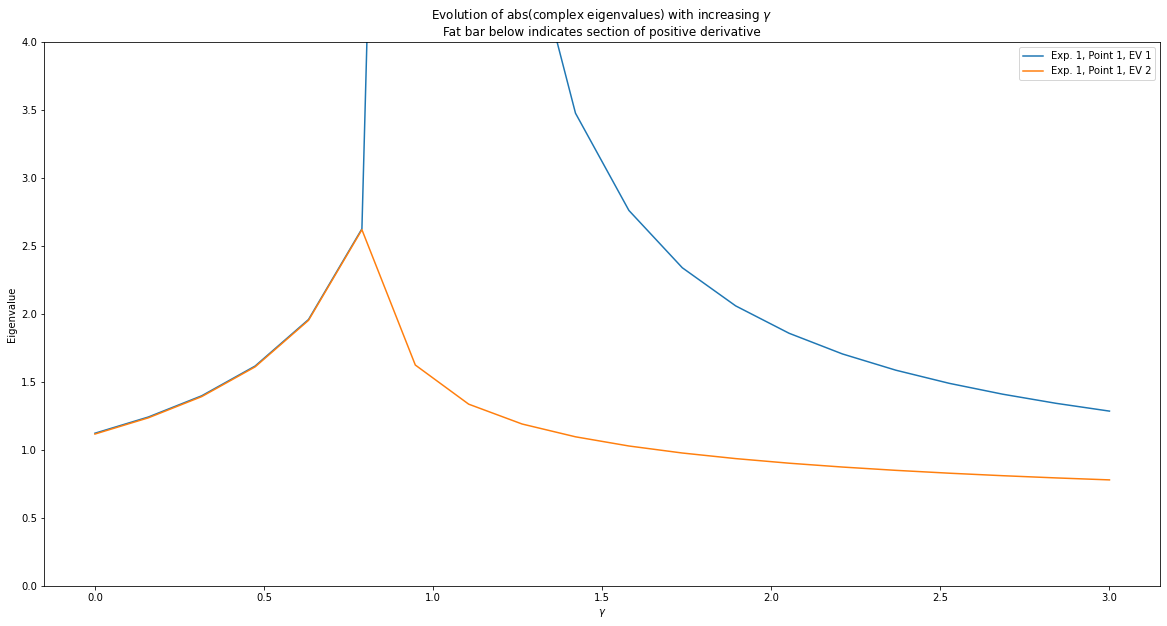

In [140]:
gammas = np.linspace(0, 3, 20)
print(gammas)

p = np.ones(2)

computed_evals = calc_evals_batch([W], [p], gammas=gammas)
plot_evals_lineplot(computed_evals, gammas)

0.0
[[ 0.5  1. ]
 [-1.   0.5]]

[0.5+1.j 0.5-1.j]
[[0.70710678+0.j         0.70710678-0.j        ]
 [0.        +0.70710678j 0.        -0.70710678j]]


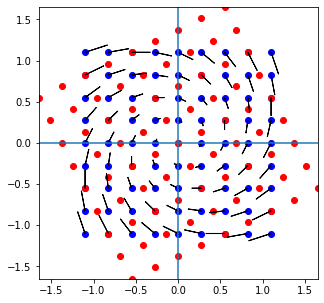

0.15789473684210525
[[ 0.5     1.    ]
 [-1.1875  0.6875]]

[0.59375+1.08568455j 0.59375-1.08568455j]
[[0.05816751-0.67361666j 0.05816751+0.67361666j]
 [0.7367884 +0.j         0.7367884 -0.j        ]]


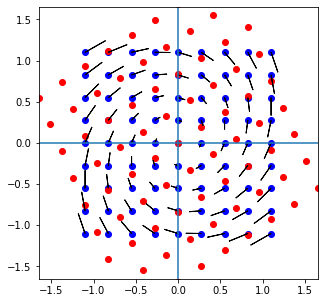

0.3157894736842105
[[ 0.5         1.        ]
 [-1.46153846  0.96153846]]

[0.73076923+1.18671143j 0.73076923-1.18671143j]
[[0.12166607-0.62565755j 0.12166607+0.62565755j]
 [0.77055175+0.j         0.77055175-0.j        ]]


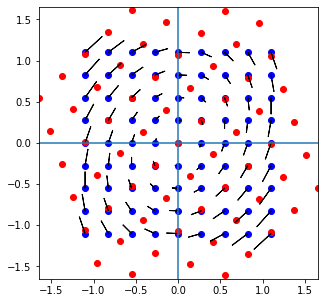

0.47368421052631576
[[ 0.5  1. ]
 [-1.9  1.4]]

[0.95+1.30288142j 0.95-1.30288142j]
[[0.19170645-0.55504615j 0.19170645+0.55504615j]
 [0.80942721+0.j         0.80942721-0.j        ]]


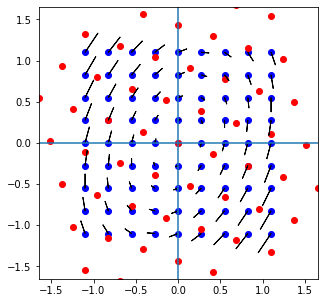

0.631578947368421
[[ 0.5         1.        ]
 [-2.71428571  2.21428571]]

[1.35714286+1.40697969j 1.35714286-1.40697969j]
[[0.26995276-0.44312106j 0.26995276+0.44312106j]
 [0.85485041+0.j         0.85485041-0.j        ]]


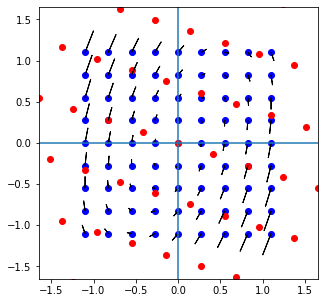

0.7894736842105263
[[ 0.5   1.  ]
 [-4.75  4.25]]

[2.375+1.1110243j 2.375-1.1110243j]
[[0.35877365-0.21259j 0.35877365+0.21259j]
 [0.90889326+0.j      0.90889326-0.j     ]]


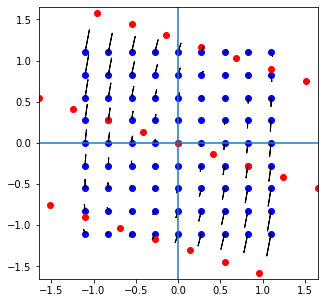

0.9473684210526315
[[  0.5   1. ]
 [-19.   18.5]]

[ 1.62599213 17.37400787]
[[-0.66403664 -0.05915895]
 [-0.74770003 -0.99824858]]


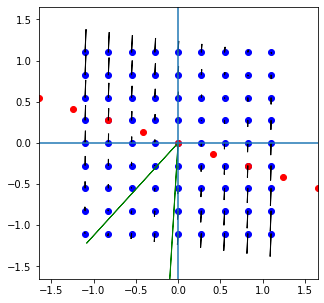

1.1052631578947367
[[  0.5   1. ]
 [  9.5 -10. ]]

[  1.33789783 -10.83789783]
[[ 0.76649784 -0.0878587 ]
 [ 0.64224688  0.99613295]]


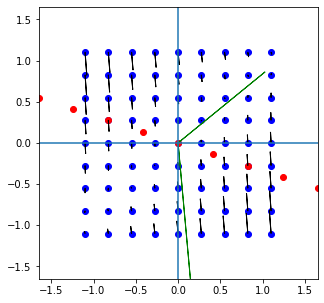

1.263157894736842
[[ 0.5  1. ]
 [ 3.8 -4.3]]

[ 1.19192497 -4.99192497]
[[ 0.82233946 -0.17914003]
 [ 0.5689972   0.98382359]]


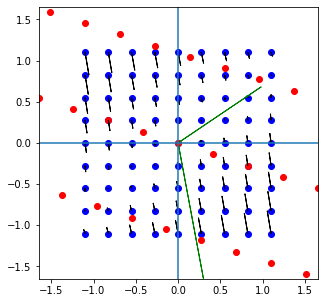

1.4210526315789473
[[ 0.5    1.   ]
 [ 2.375 -2.875]]

[ 1.09781316 -3.47281316]
[[ 0.85831991 -0.24409677]
 [ 0.51311494  0.96975088]]


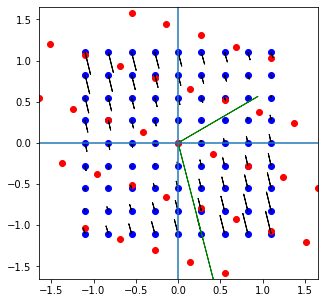

1.5789473684210527
[[ 0.5         1.        ]
 [ 1.72727273 -2.22727273]]

[ 1.03024242 -2.75751515]
[[ 0.88348426 -0.29346588]
 [ 0.46846084  0.95596955]]


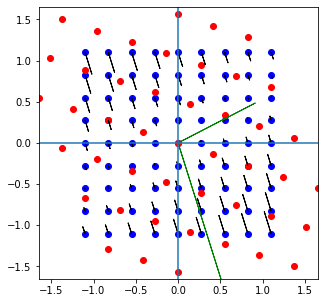

1.7368421052631577
[[ 0.5         1.        ]
 [ 1.35714286 -1.85714286]]

[ 0.97858682 -2.33572968]
[[ 0.90201975 -0.33256999]
 [ 0.43169477  0.94307858]]


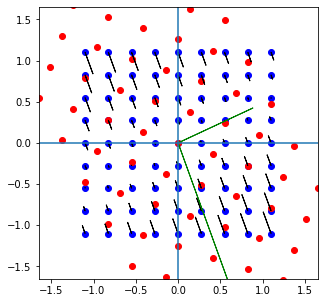

1.894736842105263
[[ 0.5         1.        ]
 [ 1.11764706 -1.61764706]]

[ 0.93742322 -2.05507028]
[[ 0.91618317 -0.36445937]
 [ 0.40075979  0.93121929]]


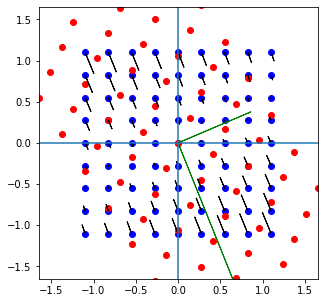

2.052631578947368
[[ 0.5   1.  ]
 [ 0.95 -1.45]]

[ 0.90363157 -1.85363157]
[[ 0.92731091 -0.39104345]
 [ 0.37429196  0.92037222]]


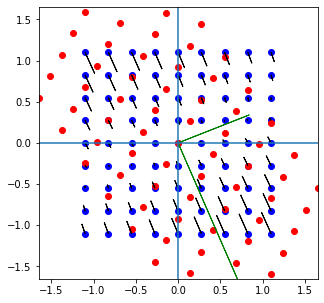

2.2105263157894735
[[ 0.5         1.        ]
 [ 0.82608696 -1.32608696]]

[ 0.87526369 -1.70135064]
[[ 0.93624799 -0.4135925 ]
 [ 0.35133987  0.91046211]]


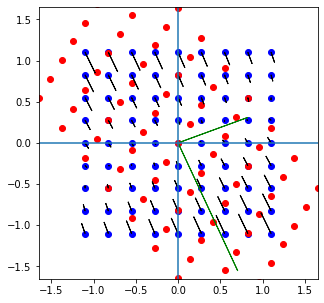

2.3684210526315788
[[ 0.5         1.        ]
 [ 0.73076923 -1.23076923]]

[ 0.85102805 -1.58179728]
[[ 0.94355551 -0.43299052]
 [ 0.33121445  0.90139848]]


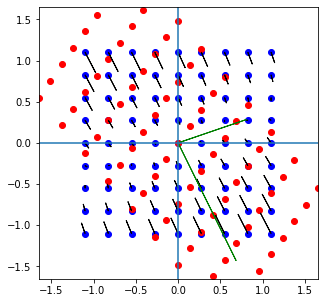

2.526315789473684
[[ 0.5         1.        ]
 [ 0.65517241 -1.15517241]]

[ 0.8300283  -1.48520071]
[[ 0.94962065 -0.44987474]
 [ 0.31340169  0.89309166]]


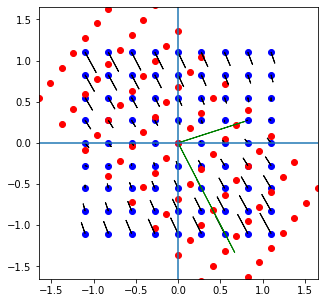

2.6842105263157894
[[ 0.5      1.     ]
 [ 0.59375 -1.09375]]

[ 0.81161937 -1.40536937]
[[ 0.95471903 -0.46471771]
 [ 0.29750894  0.88545889]]


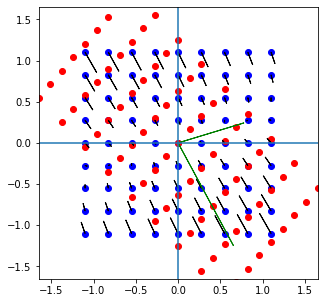

2.8421052631578947
[[ 0.5         1.        ]
 [ 0.54285714 -1.04285714]]

[ 0.79532313 -1.33818027]
[[ 0.95905195 -0.47787813]
 [ 0.28323022  0.87842615]]


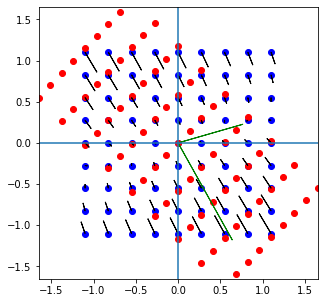

3.0
[[ 0.5  1. ]
 [ 0.5 -1. ]]

[ 0.78077641 -1.28077641]
[[ 0.96276969 -0.48963374]
 [ 0.27032301  0.87192821]]


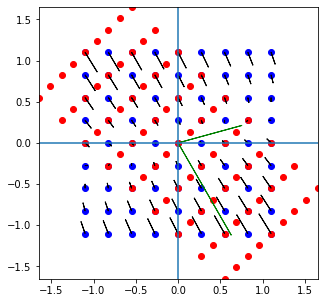

In [141]:
for gamma in gammas:
    Wp = forw_surrogate_matrix(W, p, gamma)
    print(gamma)
    print(Wp)
    print()
    
    evals, evecs = LA.eig(Wp)
    print(evals)
    print(evecs)
    plot_vector_field(Wp, figsize=(5,5))

    if not np.any(np.iscomplex(evecs)):
        plt.arrow(0, 0, *(evecs[:,0]*evals[0]), color='green')
        plt.arrow(0, 0, *(evecs[:,1]*evals[1]), color='green')
    plt.show()
    

[[1 1]
 [0 1]]

[1. 1.]
[[ 1.00000000e+00 -1.00000000e+00]
 [ 0.00000000e+00  2.22044605e-16]]


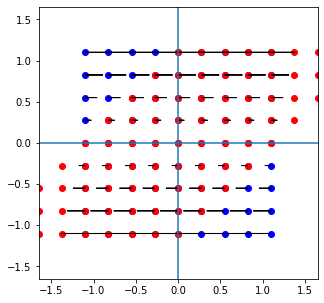

In [113]:
W = np.array([[1, 1], [0, 1]])

print(W)
print()

evals, evecs = LA.eig(W)
print(evals)
print(evecs)
plot_vector_field(W, figsize=(5,5))

In [98]:
evecs

array([[ 1.00000000e+00, -1.00000000e+00],
       [ 0.00000000e+00,  2.22044605e-16]])

In [99]:
LA.inv(evecs)

array([[1.00000000e+00, 4.50359963e+15],
       [0.00000000e+00, 4.50359963e+15]])

In [100]:
np.diag(evals)

array([[1., 0.],
       [0., 1.]])

In [102]:
evecs

array([[ 1.00000000e+00, -1.00000000e+00],
       [ 0.00000000e+00,  2.22044605e-16]])

In [119]:
evecs @ np.diag(evals) @ LA.inv(evecs)

array([[ 0.5+1.01465364e-17j,  1. -5.07326818e-18j],
       [-1. +5.07326818e-18j,  0.5+1.01465364e-17j]])

In [106]:
evecs

array([[0.70710678+0.j        , 0.70710678-0.j        ],
       [0.        +0.70710678j, 0.        -0.70710678j]])

In [115]:
for i in range(2):
    print(W @ evecs[:, i] == evecs[:, i] * evals[i])
    print(W @ evecs[:, i], evecs[:, i] * evals[i])

[ True  True]
[1. 0.] [1. 0.]
[False  True]
[-1.00000000e+00  2.22044605e-16] [-1.00000000e+00  2.22044605e-16]
